In [1]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
import numpy as np
from torch.nn import KLDivLoss
from torchvision.io import read_video
from scipy.special import kl_div

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [2]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape

time_window = 5
patch_size = (35, 35)

pos_range = max(int(time_window / 2), 1) if time_window > 1 else 0
center_index = int(patch_size[0] / 2)

step_matrix = torch.ones(patch_size + (2,))

step_w = 2 / W
step_h = 2 / H

for k in range(0, patch_size[0]):
    for l in range(0, patch_size[1]):
        step_matrix[k, l, 0] = (l - center_index) * step_w
        step_matrix[k, l, 1] = (k - center_index) * step_h

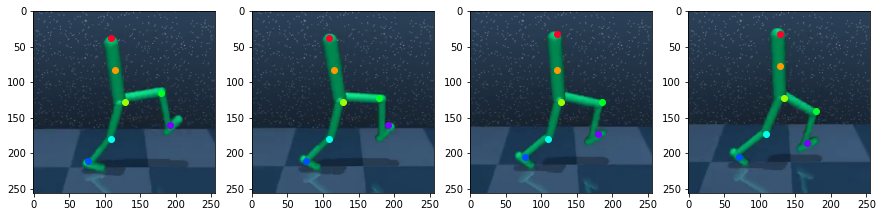

In [3]:
perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = perfect_kpt_coordinates.shape

cm = pylab.get_cmap('gist_rainbow')
perfect_kpts = kpts_2_img_coordinates(perfect_kpt_coordinates, tuple(img_tensor.shape[-2:]))
fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
for t in range(sample_size):
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    for k in range(K):
        ax[t].scatter(perfect_kpts[0, t, k, 1], perfect_kpts[0, t, k, 0], color=cm(1.*k/K))
plt.show()

In [8]:
img_t_diff = torch.empty((N, T-1, C, H, W))
for n in range(N):
    for t in range(T-1):
        img_t_diff[n, t, ...] = img_tensor[n, t, ...] - img_tensor[n, t+1, ...]


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


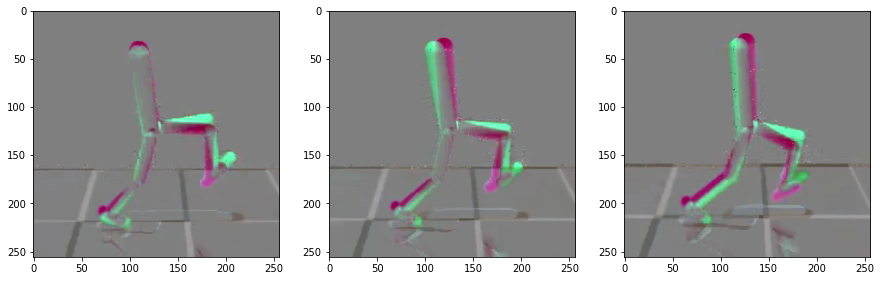

In [11]:
fig, ax = plt.subplots(1, T-1, figsize=(15, 5))
for t in range(T-1):
    print(img_t_diff[0, t].shape)
    ax[t].imshow((img_t_diff[0, t].permute(1, 2, 0) + 0.5).clip(0.0, 1.0))

In [ ]:
kpt_distances = torch.empty((N, T-1, K, 2))

for n in range(N):
    for t in range(T-1):
        for k in range(K):
        kpt_distances[n, t, k]